<a href="https://colab.research.google.com/github/elka97/MachineLearningInBusiness/blob/main/homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

**1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта**

**2. при обучении моделей обязательно использовать кроссвалидацию**

**3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
DATA_PATH = "/gdrive/My Drive/Ml_In_Business/lection3_materials/"
DATA_PATH

'/gdrive/My Drive/Ml_In_Business/lection3_materials/'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion

In [424]:
def plot_roc_curve(_y_pred, _y_true):
  sns.set(font_scale=1.5)
  sns.set_color_codes("muted")

  plt.figure(figsize=(10, 8))
  fpr, tpr, thresholds_ = roc_curve(_y_true, _y_pred, pos_label=1)
  lw = 2
  plt.plot(fpr, tpr, lw=lw, label=f'ROC curve')
  plt.plot([0, 1], [0, 1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  # plt.savefig("ROC.png")
  plt.show()
  return

In [402]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [403]:
df = pd.read_csv(f'{DATA_PATH}train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [404]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)

In [406]:
print(f"Classes balance:\n\nTrain\n{y_train.value_counts()}\n\nTest\n{y_test.value_counts()}")

#  +- balanced target

Classes balance:

Train
1    26299
0    26201
Name: cardio, dtype: int64

Test
0    8820
1    8680
Name: cardio, dtype: int64


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [407]:
from sklearn.preprocessing import StandardScaler

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [408]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [427]:
def classify_by(ppl, x_train, y_train, x_test, y_test):

  cv_scores = cross_validate(ppl, x_train, y_train, scoring=("precision", "recall", "roc_auc", "f1"), cv=16, return_estimator=True)
 
  cv_precision = cv_scores['test_precision'].mean()
  cv_recall = cv_scores['test_recall'].mean()
  cv_fscore = cv_scores['test_f1'].mean()
  cv_rocauc = cv_scores['test_roc_auc'].mean()

  print(f"Cross validation scores: F-Score={cv_fscore:.3f}, Precision={cv_precision:.3f}, Recall={cv_recall:.3f}, Roc Auc={cv_rocauc:.3f}")   

  # обучим пайплайн на всем тренировочном датасете
  ppl.fit(x_train, y_train)
  _y_pred = ppl.predict_proba(x_test)[:, 1]

  _rocauc= roc_auc_score(y_test, _y_pred)

  print(f"Test set scores: ")

  b=1
  _precision, _recall, _thresholds = precision_recall_curve(y_test.values, _y_pred)
  _fscore = (1+b**2)*(_precision * _recall) / (b**2*_precision + _recall)
  # locate the index of the largest f score
  ix = np.argmax(_fscore)
  print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc Auc=%.3f' % (_thresholds[ix], 
                                                                          _fscore[ix],
                                                                          _precision[ix],
                                                                          _recall[ix],
                                                                          _rocauc))  

  plot_roc_curve(_y_pred=_y_pred, _y_true=y_test) 

  return [_precision[ix], _recall[ix], _fscore[ix], _rocauc, cv_precision, cv_recall, cv_fscore, cv_rocauc]
  

Добавим классификатор и запустим кросс-валидацию

In [428]:
results = pd.DataFrame(columns=["test_precision", "test_recall", "test_f_score", "test_roc-auc", "cv_precision", "cv_recall", "cv_f_score", "cv_roc-auc"])
results

,test_precision,test_recall,test_f_score,test_roc-auc,cv_precision,cv_recall,cv_f_score,cv_roc-auc


In [429]:
logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

random_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

random_forest_hyper = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=2, random_state = 42)),
]) 

Cross validation scores: F-Score=0.711, Precision=0.746, Recall=0.679, Roc Auc=0.787
Test set scores: 
Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838, Roc Auc=0.784


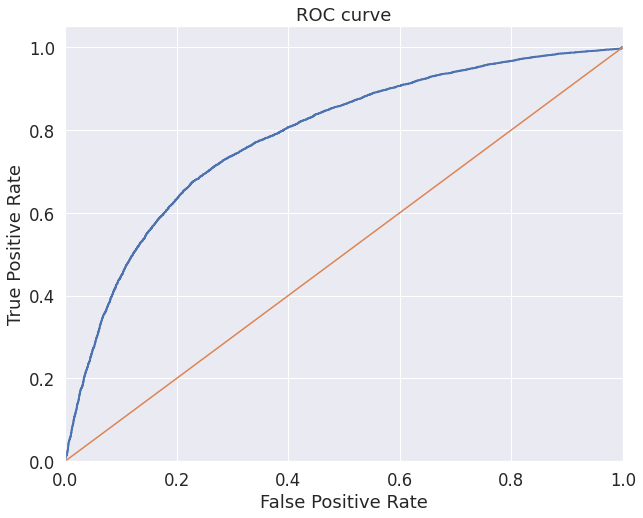

In [430]:
logreg_scores = classify_by(ppl=logreg, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
results.loc["logreg"] = logreg_scores

Cross validation scores: F-Score=0.711, Precision=0.720, Recall=0.702, Roc Auc=0.773
Test set scores: 
Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816, Roc Auc=0.771


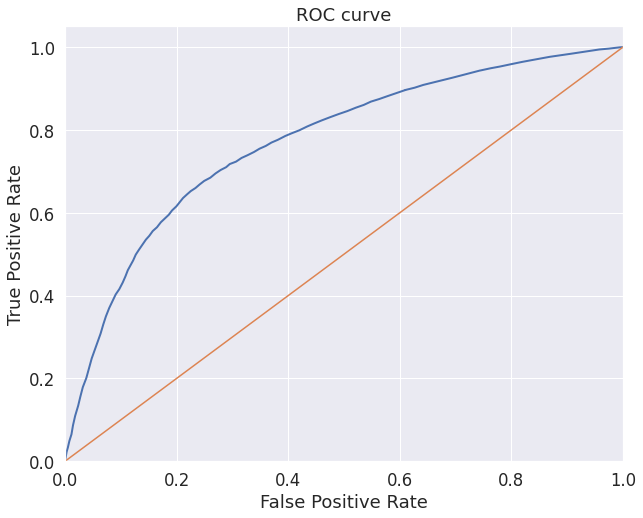

In [431]:
forest_scores = classify_by(ppl=random_forest, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
results.loc["randomforest_default"] = forest_scores

Cross validation scores: F-Score=0.704, Precision=0.760, Recall=0.656, Roc Auc=0.785
Test set scores: 
Best Threshold=0.434271, F-Score=0.734, Precision=0.668, Recall=0.814, Roc Auc=0.786


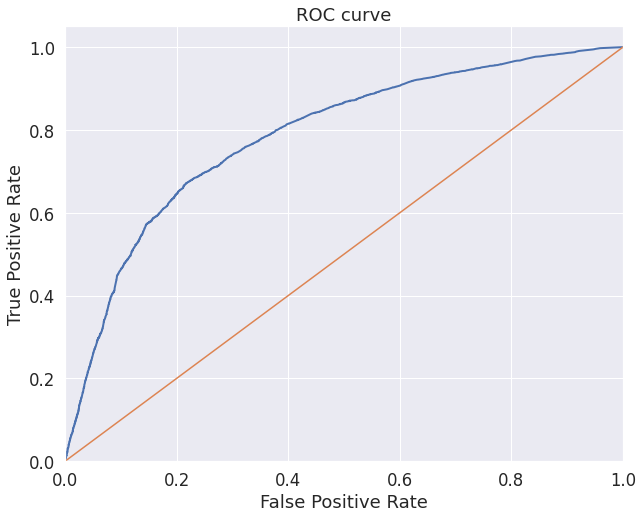

In [432]:
forest_scores_hyper = classify_by(ppl=random_forest_hyper, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
results.loc["randforest_hyper"] = forest_scores_hyper

In [433]:
# Scores comparison
results

,test_precision,test_recall,test_f_score,test_roc-auc,cv_precision,cv_recall,cv_f_score,cv_roc-auc
logreg,0.647431,0.837558,0.730323,0.784035,0.745866,0.678694,0.710637,0.786740
randomforest_default,0.642669,0.815553,0.718863,0.771037,0.720373,0.702421,0.711238,0.773450
randforest_hyper,0.668370,0.813594,0.733867,0.785843,0.760131,0.656108,0.704187,0.784971


Лучший Roc Auc/F-Score на тестовых данных показала модель Random forest с минимальным подбором гипер параметра, на кросс валидации best f-score - логистическая регресиия с дефолтными гипер-параметрами

5 (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

в таком случае больше подходит F-score с подбором бета